BOX 1: reading packages

In [309]:
import pandas as pd
from itertools import combinations
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm, shapiro, chisquare
import statsmodels.formula.api as sfm
from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

BOX 2 reading the csv + checking each column for null values

In [310]:
df = pd.read_csv('udemy_database.csv')
has_nulls = df.isnull().any()
print(has_nulls)

course_id              False
course_title           False
url                    False
is_paid                False
price                  False
num_subscribers        False
num_reviews            False
num_lectures           False
level                  False
content_duration       False
published_timestamp    False
subject                False
dtype: bool


BOX 3 checking for duplicates - there where 6 duplicates

In [311]:
course_counts = df['course_id'].value_counts()

duplicates = course_counts[course_counts > 1]
print(duplicates)

df.drop_duplicates(subset='course_id', inplace=True)


course_id
1035638    2
185526     2
1084454    2
837322     2
1157298    2
28295      2
Name: count, dtype: int64


BOX 4: detecting outliers
method: https://bpb-us-w2.wpmucdn.com/sites.umassd.edu/dist/f/1316/files/2023/01/Statistics-for-Nursing-and-Allied-Health-PDFDrive-.pdf#page=34
Column: course_id, Outliers Count: 0
Column: price, Outliers Count: 0
Column: num_subscribers, Outliers Count: 48
Column: num_reviews, Outliers Count: 27
Column: num_lectures, Outliers Count: 73
Column: content_duration, Outliers Count: 69

In [312]:
outliers_dict = {}

for column in df.select_dtypes(include=['float64', 'int64']).columns:
    mean = df[column].mean()
    std_dev = df[column].std()

    outliers = df[(df[column] < (mean - 3 * std_dev)) | (df[column] > (mean + 3 * std_dev))]

    outliers_dict[column] = outliers
    outliers_count = len(outliers)
    
    print(f"Column: {column}, Outliers Count: {outliers_count}")
    # print(outliers, "\n")


Column: course_id, Outliers Count: 0
Column: price, Outliers Count: 0
Column: num_subscribers, Outliers Count: 48
Column: num_reviews, Outliers Count: 27
Column: num_lectures, Outliers Count: 73
Column: content_duration, Outliers Count: 69


In [358]:
mean = df["content_duration"].mean()
std_dev = df["content_duration"].std()

    # Find outliers using Z-score method (values more than 3 std deviations away from mean)
outliers = df[(df["content_duration"] < (mean - 3 * std_dev)) | (df["content_duration"] > (mean + 3 * std_dev))]
    

# Save the outliers to a CSV file
outliers.to_csv('outliers_content_duration.csv', index=False)

print("Outliers saved to 'outliers.csv'.")


Outliers saved to 'outliers.csv'.


BOX 4: the outliers intersection based on numeric variables

In [315]:
common_outliers_pairwise = {}

for col1, col2 in combinations(outliers_dict.keys(), 2):
    outliers_col1 = set(outliers_dict[col1]['course_id']) if isinstance(outliers_dict[col1], pd.DataFrame) else set(outliers_dict[col1])
    outliers_col2 = set(outliers_dict[col2]['course_id']) if isinstance(outliers_dict[col2], pd.DataFrame) else set(outliers_dict[col2])

    common_outliers = outliers_col1.intersection(outliers_col2)

    common_outliers_pairwise[f"{col1} & {col2}"] = common_outliers

for columns, common_outliers in common_outliers_pairwise.items():
    print(f"Common outliers for {columns}:", len(common_outliers))
    for course_id in common_outliers:
        print(f"  - Course ID {course_id}")
    print()



BOX 6: plotting the data to better see the outliers

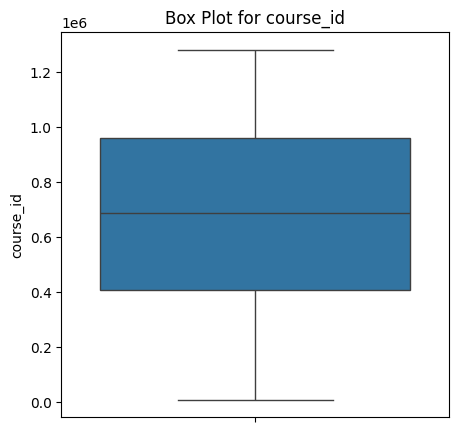

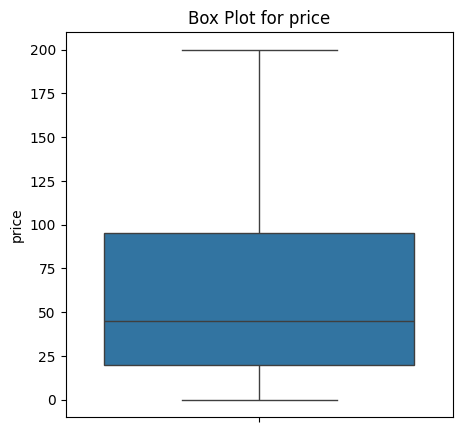

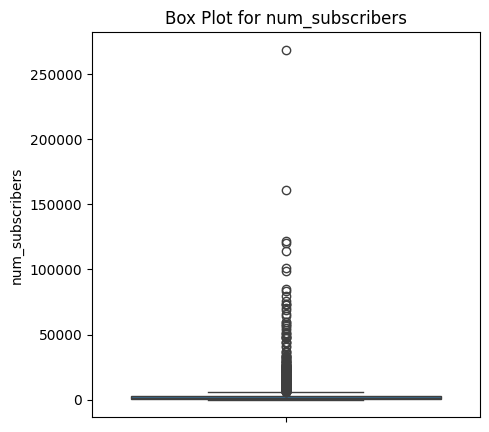

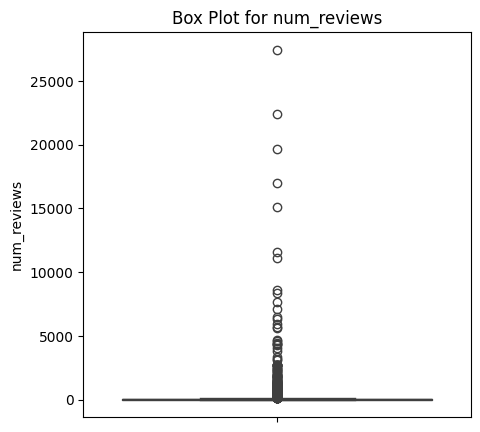

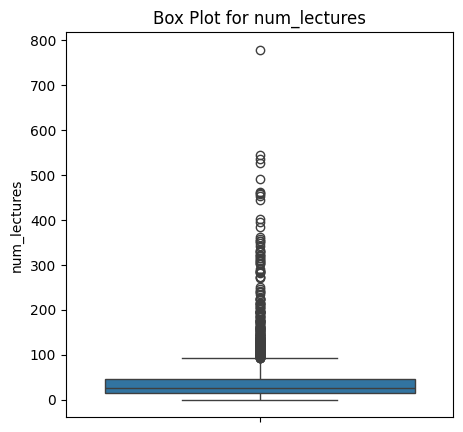

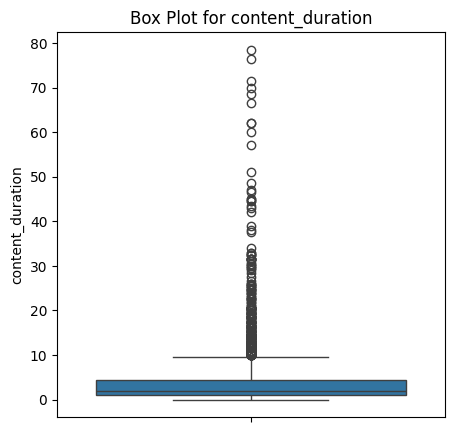

In [316]:
numerical_cols = df.select_dtypes(include=['float64', 'int64']).columns

for column in numerical_cols:
    plt.figure(figsize=(5, 5))
    sns.boxplot(y=df[column])  
    plt.title(f'Box Plot for {column}')
    plt.ylabel(column)
    plt.show()

BOX 7 Perform a Chi-Square Test for Goodness of Fit on observed categorical counts.

In [317]:
def chi_square_test(observed_values, alpha=0.05):

    expected_counts = [sum(observed_values) / len(observed_values)] * len(observed_values)

    chi2_stat, p_value = chisquare(f_obs=observed_values, f_exp=expected_counts)

    result = "reject the null hypothesis" if p_value < alpha else "fail to reject the null hypothesis"
    
    # print(f"Chi-Square Statistic: {chi2_stat}")
    # print(f"P-Value: {p_value}")
    # print(f"Result: {result}")

    # print(f"Observed Values: {observed_values}")
    # print(f"Expected Values: {expected_counts}")
    # print(f"Chi-Square Statistic: {chi2_stat}")
    # print(f"P-Value: {p_value}")
    # print(f"Result: {result}")
    
    return {
        f"Chi-Square Statistic: {chi2_stat}",
        f"P-Value: {p_value}",
        f"Result: {result}"
    }

In [318]:
outliers_dict = {}

for column in df.select_dtypes(include=['float64', 'int64']).columns:
    mean = df[column].mean()
    std_dev = df[column].std()

    outliers = df[(df[column] < (mean - 3 * std_dev)) | (df[column] > (mean + 3 * std_dev))]

    outliers_dict[column] = outliers
    outliers_count = len(outliers)
    
    print(f"Column: {column}, Outliers Count: {outliers_count}")
    # print(outliers, "\n")


Column: course_id, Outliers Count: 0
Column: price, Outliers Count: 0
Column: num_subscribers, Outliers Count: 48
Column: num_reviews, Outliers Count: 27
Column: num_lectures, Outliers Count: 73
Column: content_duration, Outliers Count: 69


BOX 8 BARCHART: count all the courses taking into account the subject

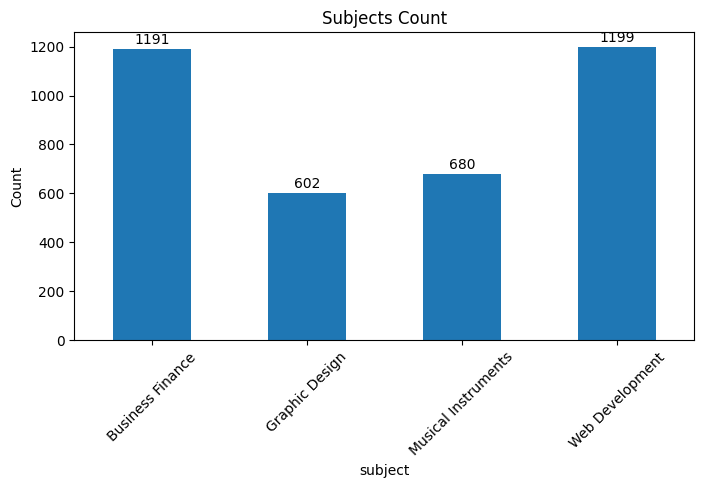

In [319]:
category = df.groupby('subject')['subject'].count()

plt.figure(figsize=(8, 4))
for i, v in enumerate(category.values):
    plt.text(i, v + 10, str(v), ha='center', va='bottom')
category.plot(kind='bar')
plt.title('Subjects Count')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

BOX 9: Chi square for courses based on subj
H₀: There is no statistical difference in the number of couses per subject
H₁: There is a statistical difference in the number of couses per subject for at least one subject

In [320]:
observed_cat = category.values  
chi_square_test(observed_cat)

{'Chi-Square Statistic: 337.67973856209153',
 'P-Value: 6.938242224702548e-73',
 'Result: reject the null hypothesis'}

BOX 10 BARCHART: avg duration per subject

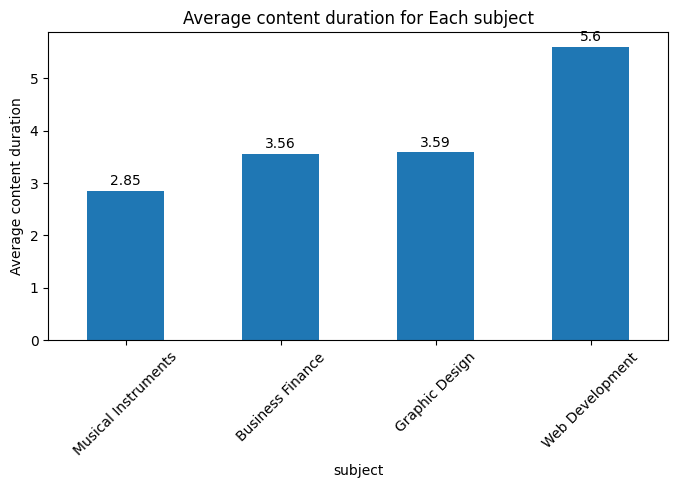

In [321]:
avg_duration_subj = df.groupby('subject')['content_duration'].mean().sort_values(ascending=True)

plt.figure(figsize=(8, 4) ,linewidth=2)
for i, v in enumerate(avg_duration_subj.values):
    plt.text(i, round(v, 2) + .05, str(round(v, 2)), ha='center', va='bottom')
avg_duration_subj.plot(kind='bar')
plt.title('Average content duration for Each subject')
plt.xlabel('subject')
plt.ylabel('Average content duration')
plt.xticks(rotation=45)
plt.show()

BOX 11 Chi Square for avr duration based on each subject
H₀: all subjects have a similar value for the avg duration 
H₁: at least one subject has a different value for the avg duration

In [322]:
observed_avg_duration = avg_duration_subj.values
chi_square_test(observed_avg_duration)

{'Chi-Square Statistic: 1.0738276876778154',
 'P-Value: 0.7833956419700129',
 'Result: fail to reject the null hypothesis'}

BOX 12 BARCHART: total number of subscribers enrolled for each subject

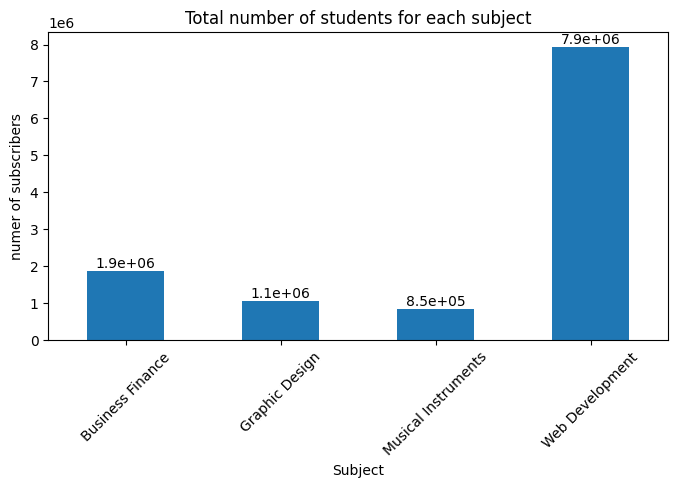

In [323]:
total_enrolled_stud = df.groupby('subject')['num_subscribers'].sum()

plt.figure(figsize=(8, 4))

for i, v in enumerate(total_enrolled_stud.values):
    scientific_notation = "{:.1e}".format(v) 
    plt.text(i, v + v * 0.001, scientific_notation, ha='center', va='bottom')

total_enrolled_stud.plot(kind='bar')
plt.title('Total number of students for each subject')
plt.xlabel('Subject')
plt.ylabel('numer of subscribers')
plt.xticks(rotation=45)
plt.show()

BOX 13 Chi Square for total number of subscribers enrolled in each subject
H₀: all subjects have a similar number of students enrolled
H₁: at least one subject has a different number of students enrolled

In [324]:
observed_avg_subscribers = total_enrolled_stud.values
chi_square_test(observed_avg_subscribers)

{'Chi-Square Statistic: 11616610.926223781',
 'P-Value: 0.0',
 'Result: reject the null hypothesis'}

BOX 14 BARCHART: total number of reviews for each subject

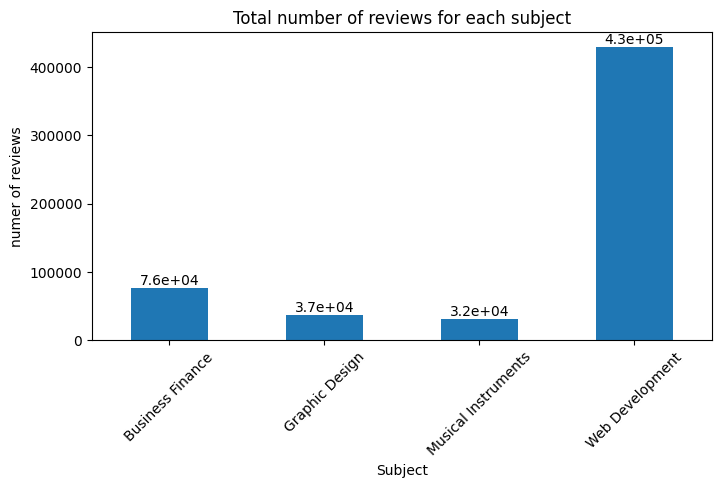

In [325]:
total_reviews = df.groupby('subject')['num_reviews'].sum()

plt.figure(figsize=(8, 4))

for i, v in enumerate(total_reviews.values):
    scientific_notation = "{:.1e}".format(v) 
    plt.text(i, v + v * 0.001, scientific_notation, ha='center', va='bottom')

total_reviews.plot(kind='bar')
plt.title('Total number of reviews for each subject')
plt.xlabel('Subject')
plt.ylabel('numer of reviews')
plt.xticks(rotation=45)
plt.show()

BOX 15: Chi Square test for total number of reviews
H0: The is no significant difference in the number of reviews across all subjects
H1: At least one subject has a different number of reviews that others

In [326]:
observed_total_reviews = total_reviews.values
chi_square_test(observed_total_reviews)

{'Chi-Square Statistic: 767589.4577879331',
 'P-Value: 0.0',
 'Result: reject the null hypothesis'}

BOX 16 BARCHART: total number of professors for each subject

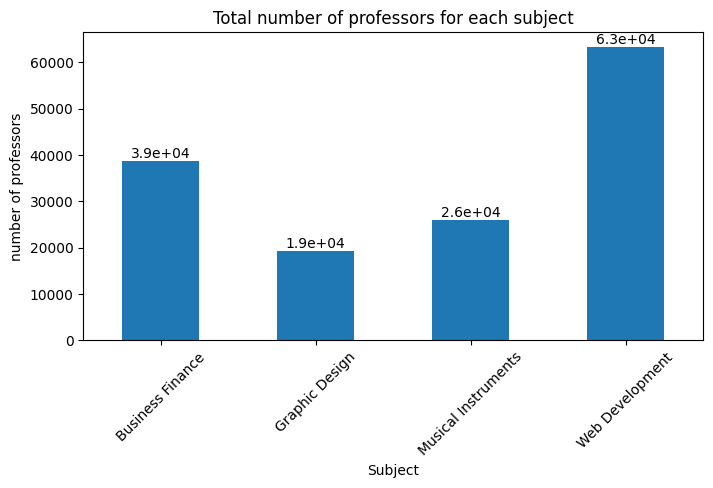

In [327]:
total_professors = df.groupby('subject')['num_lectures'].sum()

plt.figure(figsize=(8, 4))

for i, v in enumerate(total_professors.values):
    scientific_notation = "{:.1e}".format(v) 
    plt.text(i, v + v * 0.001, scientific_notation, ha='center', va='bottom')

total_professors.plot(kind='bar')
plt.title('Total number of professors for each subject')
plt.xlabel('Subject')
plt.ylabel('number of professors')
plt.xticks(rotation=45)
plt.show()

BOX 17: Chi Square for number of professors
H0: There is no statistical difference between the number of professors per subject
H1: At last one subject has a different number of professors than the others

In [328]:
observed_total_professors= total_professors.values
chi_square_test(observed_total_professors)

{'Chi-Square Statistic: 30658.86730893178',
 'P-Value: 0.0',
 'Result: reject the null hypothesis'}

BOX 18 BARCHART: avg prices for each subject

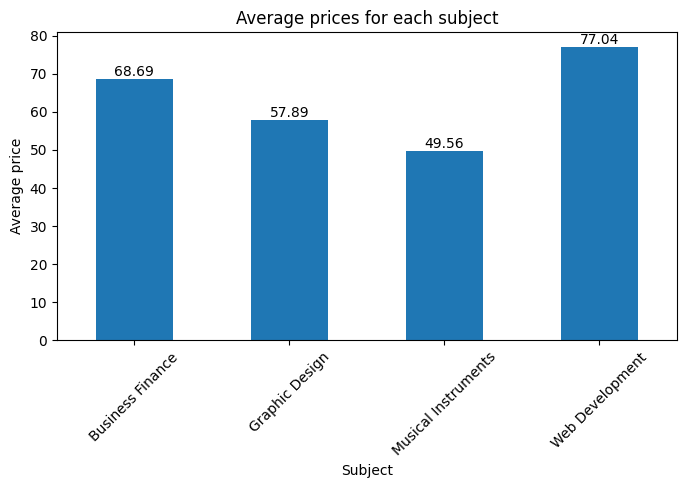

In [329]:
avg_price = df.groupby('subject')['price'].mean()

plt.figure(figsize=(8, 4) ,linewidth=2)
for i, v in enumerate(avg_price.values):
    plt.text(i, round(v,2) + .05, str(round(v, 2)), ha='center', va='bottom')
avg_price.plot(kind='bar')
plt.title('Average prices for each subject')
plt.xlabel('Subject')
plt.ylabel('Average price')
plt.xticks(rotation=45)
plt.show()

BOX 19: Chi Square test for avg prices per subject
H0: There is no statistical difference between the avg price per subject
H1: At last one subject has a different agv price than the others

In [330]:
observed_avg_price = avg_price.values
chi_square_test(observed_avg_price)

{'Chi-Square Statistic: 6.88579963278157',
 'P-Value: 0.07562818840722958',
 'Result: fail to reject the null hypothesis'}

BOX 20: Checking price values over time for every category

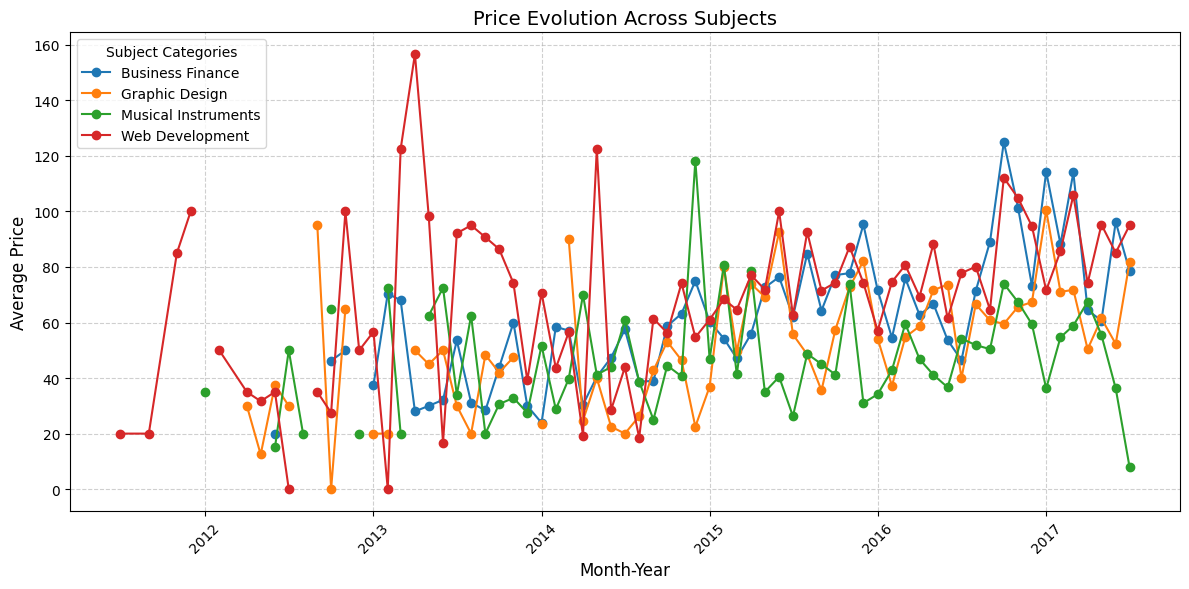

In [331]:
df["published_timestamp"] = pd.to_datetime(df["published_timestamp"])
df["Month-Year"] = df["published_timestamp"].dt.strftime("%b-%Y")

grouped = df.groupby(["subject", "Month-Year"], as_index=False)["price"].mean()

pivoted = grouped.pivot(index="Month-Year", columns="subject", values="price")

pivoted.index = pd.to_datetime(pivoted.index, format="%b-%Y")
pivoted = pivoted.sort_index()

plt.figure(figsize=(12, 6))
for category in pivoted.columns:
    plt.plot(pivoted.index, pivoted[category], marker="o", label=category)

plt.title("Price Evolution Across Subjects", fontsize=14)
plt.xlabel("Month-Year", fontsize=12)
plt.ylabel("Average Price", fontsize=12)
plt.legend(title="Subject Categories")
plt.grid(visible=True, linestyle="--", alpha=0.6)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

BOX 21: Avg price per subject taking into account all categories

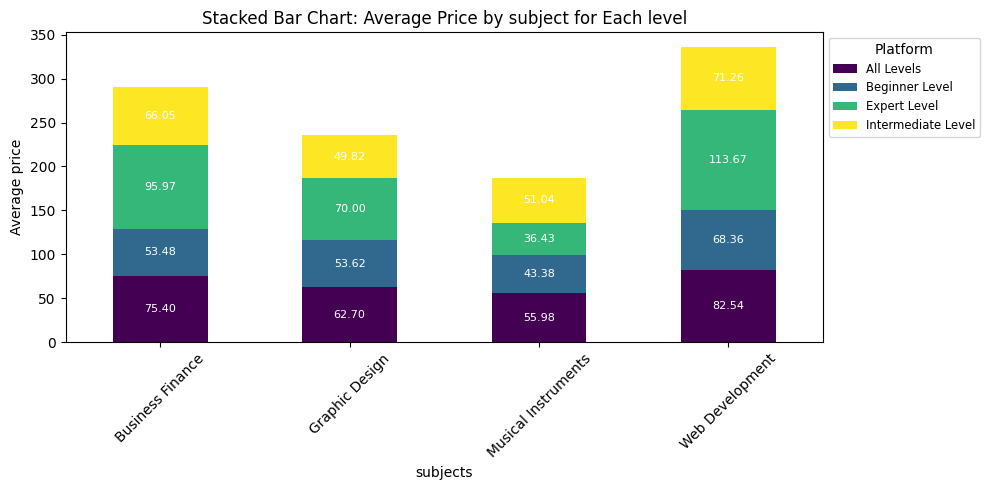

In [332]:
avg_price_per_category = df.groupby(['subject', 'level'])['price'].mean().unstack()

ax = avg_price_per_category.plot(
    kind='bar',
    stacked=True,
    figsize=(10, 5),
    colormap='viridis'
)


for i, bar_group in enumerate(ax.containers):
    for bar in bar_group:
        if bar.get_height() > 0:  
            height = bar.get_height()
            ax.text(
                bar.get_x() + bar.get_width() / 2,  
                bar.get_y() + height / 2,          
                f'{height:.2f}',                   
                ha='center', va='center', fontsize=8, color='white'
            )

plt.title('Stacked Bar Chart: Average Price by subject for Each level')
plt.xlabel('subjects')
plt.ylabel('Average price')
plt.xticks(rotation=45)
plt.legend(title='Platform', fontsize='small', loc='upper left', bbox_to_anchor=(1.0, 1.0))
plt.tight_layout()

plt.show()

BOX 20: Checking distribution for price

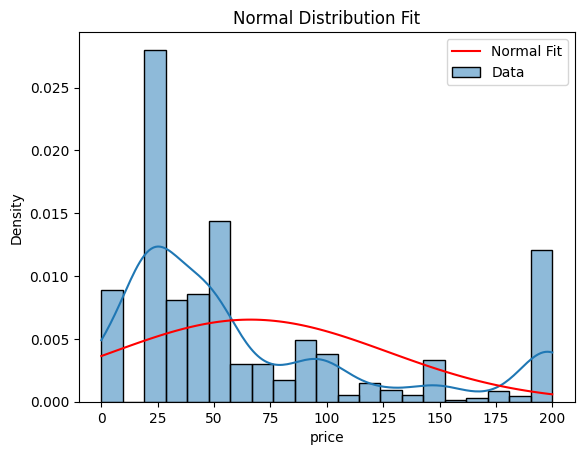

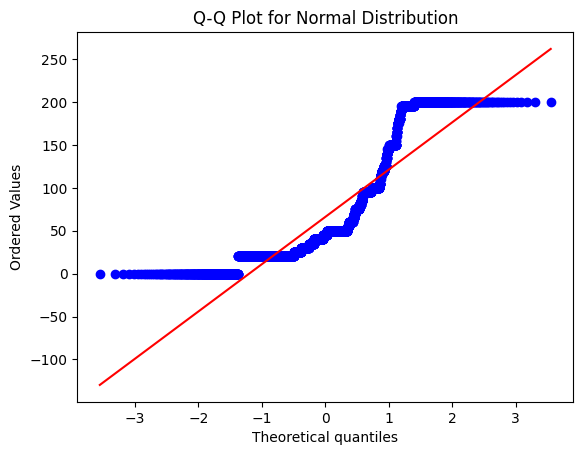

Shapiro-Wilk Test: Stat=0.8125917569824538, p=2.8372585758096045e-54
Data does not follow a normal distribution.


In [333]:
prices = df['price']

sns.histplot(prices, kde=True, stat='density', label='Data')
mean, std = prices.mean(), prices.std()
x = np.linspace(prices.min(), prices.max(), 100)
plt.plot(x, stats.norm.pdf(x, mean, std), label='Normal Fit', color='red')
plt.title('Normal Distribution Fit')
plt.legend()
plt.show()

stats.probplot(prices, dist="norm", plot=plt)
plt.title('Q-Q Plot for Normal Distribution')
plt.show()

stat, p = stats.shapiro(prices)
print(f'Shapiro-Wilk Test: Stat={stat}, p={p}')
if p > 0.05:
    print("Data follows a normal distribution.")
else:
    print("Data does not follow a normal distribution.")


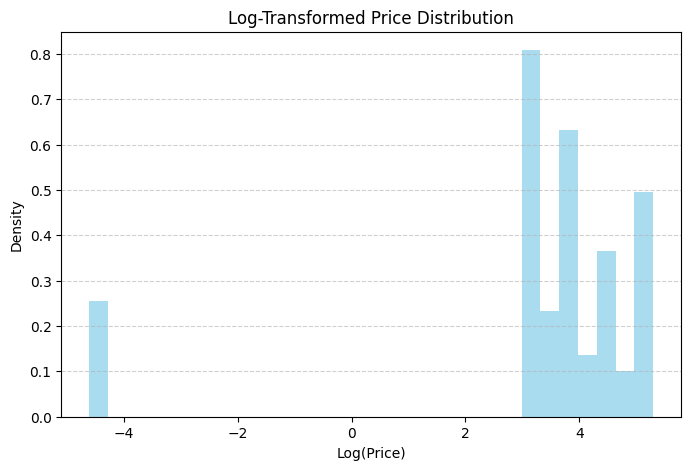

In [334]:
df['price_log'] = np.log(df['price'].replace(0, 0.01))

# Plot the transformed distribution
plt.figure(figsize=(8, 5))
plt.hist(df['price_log'], bins=30, color='skyblue', alpha=0.7, density=True)
plt.title('Log-Transformed Price Distribution')
plt.xlabel('Log(Price)')
plt.ylabel('Density')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()


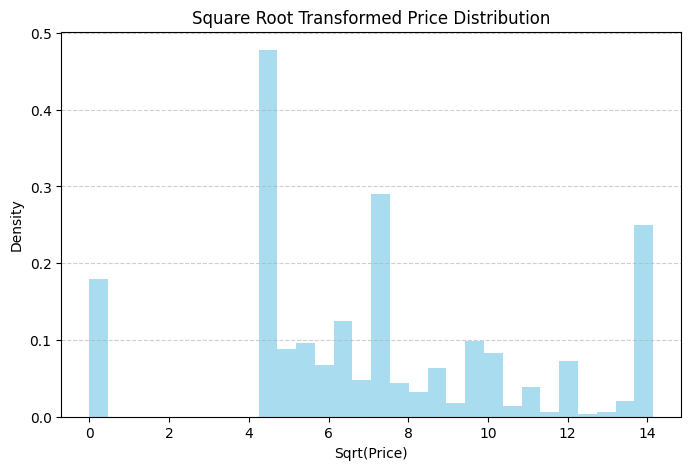

In [335]:
df['price_sqrt'] = np.sqrt(df['price'])

plt.figure(figsize=(8, 5))
plt.hist(df['price_sqrt'], bins=30, color='skyblue', alpha=0.7, density=True)
plt.title('Square Root Transformed Price Distribution')
plt.xlabel('Sqrt(Price)')
plt.ylabel('Density')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

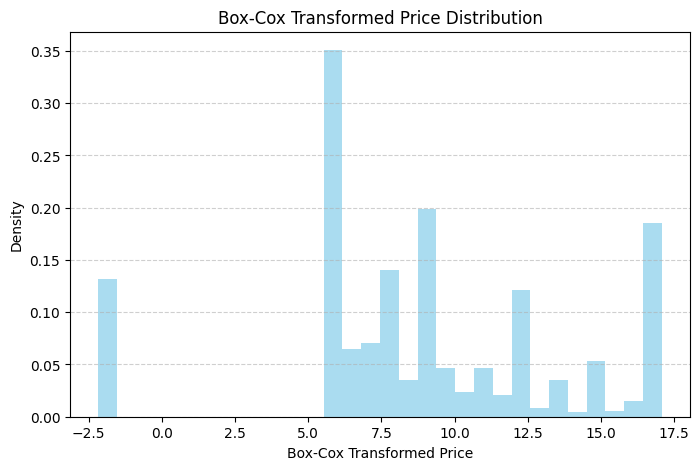

In [336]:
from scipy.stats import boxcox

# Ensure no zero prices by replacing zero with a small value
df['price_adjusted'] = df['price'].replace(0, 0.01)

# Apply Box-Cox transformation
df['price_boxcox'], lambda_ = boxcox(df['price_adjusted'])

# Plot the transformed distribution
plt.figure(figsize=(8, 5))
plt.hist(df['price_boxcox'], bins=30, color='skyblue', alpha=0.7, density=True)
plt.title('Box-Cox Transformed Price Distribution')
plt.xlabel('Box-Cox Transformed Price')
plt.ylabel('Density')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()


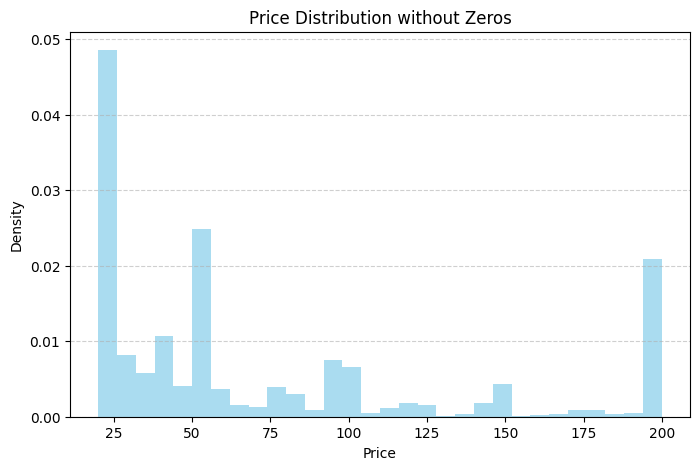

Shapiro-Wilk Test: Stat = 0.7862613045584798, p-value = 7.020117445293386e-55


In [337]:
# Remove rows where price is zero
df_non_zero_price = df[df['price'] > 0]

# Plot the original distribution without zeros
plt.figure(figsize=(8, 5))
plt.hist(df_non_zero_price['price'], bins=30, color='skyblue', alpha=0.7, density=True)
plt.title('Price Distribution without Zeros')
plt.xlabel('Price')
plt.ylabel('Density')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

from scipy import stats

# Shapiro-Wilk Test for normality
stat, p_value = stats.shapiro(df_non_zero_price['price'])
print(f"Shapiro-Wilk Test: Stat = {stat}, p-value = {p_value}")



In [338]:
# params = stats.expon.fit(prices)  
# sns.histplot(prices, kde=False, stat='density', label='Data')
# plt.plot(x, stats.expon.pdf(x, *params), label='Exponential Fit', color='green')
# plt.title('Exponential Distribution Fit')
# plt.legend()
# plt.show()

# stats.probplot(prices, dist="expon", sparams=params, plot=plt)
# plt.title('Q-Q Plot for Exponential Distribution')
# plt.show()

# # Kolmogorov-Smirnov Test
# stat, p = stats.kstest(prices, 'expon', args=params)
# print(f'KS Test for Exponential: Stat={stat}, p={p}')
# if p > 0.05:
#     print("Data follows an exponential distribution.")
# else:
#     print("Data does not follow an exponential distribution.")

In [339]:
# log_prices = np.log1p(prices)  # log(1+x) to handle zeros
# sns.histplot(log_prices, kde=True, stat='density', label='Log Data')
# plt.title('Logarithmic Distribution Fit')
# plt.legend()
# plt.show()

# # Q-Q Plot
# stats.probplot(log_prices, dist="norm", plot=plt)
# plt.title('Q-Q Plot for Logarithmic Distribution')
# plt.show()

# # Shapiro-Wilk Test
# stat, p = stats.shapiro(log_prices)
# print(f'Shapiro-Wilk Test on Log Transformed Data: Stat={stat}, p={p}')
# if p > 0.05:
#     print("Log-transformed data follows a normal distribution.")
# else:
#     print("Log-transformed data does not follow a normal distribution.")

In [340]:
# # Fit Gamma Distribution
# params = stats.gamma.fit(prices)
# sns.histplot(prices, kde=False, stat='density', label='Data')
# plt.plot(x, stats.gamma.pdf(x, *params), label='Gamma Fit', color='purple')
# plt.title('Gamma Distribution Fit')
# plt.legend()
# plt.show()

# # Kolmogorov-Smirnov Test
# stat, p = stats.kstest(prices, 'gamma', args=params)
# print(f'KS Test for Gamma: Stat={stat}, p={p}')
# if p > 0.05:
#     print("Data follows a gamma distribution.")
# else:
#     print("Data does not follow a gamma distribution.")


In [341]:
# # Fit Weibull Distribution
# params = stats.weibull_min.fit(prices)
# sns.histplot(prices, kde=False, stat='density', label='Data')
# plt.plot(x, stats.weibull_min.pdf(x, *params), label='Weibull Fit', color='orange')
# plt.title('Weibull Distribution Fit')
# plt.legend()
# plt.show()

# # Kolmogorov-Smirnov Test
# stat, p = stats.kstest(prices, 'weibull_min', args=params)
# print(f'KS Test for Weibull: Stat={stat}, p={p}')
# if p > 0.05:
#     print("Data follows a Weibull distribution.")
# else:
#     print("Data does not follow a Weibull distribution.")


In [342]:
# # Normalize data to fit [0, 1]
# normalized_prices = (prices - prices.min()) / (prices.max() - prices.min())

# # Fit Beta Distribution
# params = stats.beta.fit(normalized_prices)
# sns.histplot(normalized_prices, kde=False, stat='density', label='Data')
# plt.plot(x, stats.beta.pdf(x, *params), label='Beta Fit', color='green')
# plt.title('Beta Distribution Fit')
# plt.legend()
# plt.show()

# # Kolmogorov-Smirnov Test
# stat, p = stats.kstest(normalized_prices, 'beta', args=params)
# print(f'KS Test for Beta: Stat={stat}, p={p}')
# if p > 0.05:
#     print("Data follows a beta distribution.")
# else:
#     print("Data does not follow a beta distribution.")


In [343]:
# # Fit Log-Normal Distribution
# params = stats.lognorm.fit(prices)
# sns.histplot(prices, kde=False, stat='density', label='Data')
# plt.plot(x, stats.lognorm.pdf(x, *params), label='Log-Normal Fit', color='blue')
# plt.title('Log-Normal Distribution Fit')
# plt.legend()
# plt.show()

# # Kolmogorov-Smirnov Test
# stat, p = stats.kstest(prices, 'lognorm', args=params)
# print(f'KS Test for Log-Normal: Stat={stat}, p={p}')
# if p > 0.05:
#     print("Data follows a log-normal distribution.")
# else:
#     print("Data does not follow a log-normal distribution.")


In [344]:
# # Fit Chi-Square Distribution
# params = stats.chi2.fit(prices)
# sns.histplot(prices, kde=False, stat='density', label='Data')
# plt.plot(x, stats.chi2.pdf(x, *params), label='Chi-Square Fit', color='brown')
# plt.title('Chi-Square Distribution Fit')
# plt.legend()
# plt.show()

# # Kolmogorov-Smirnov Test
# stat, p = stats.kstest(prices, 'chi2', args=params)
# print(f'KS Test for Chi-Square: Stat={stat}, p={p}')
# if p > 0.05:
#     print("Data follows a chi-square distribution.")
# else:
#     print("Data does not follow a chi-square distribution.")


In [345]:
# from sklearn.mixture import GaussianMixture

# gmm = GaussianMixture(n_components=2, random_state=42)  # Adjust n_components as needed
# gmm.fit(prices.values.reshape(-1, 1))
# sns.histplot(prices, kde=False, stat="density", label="Data")
# x = np.linspace(prices.min(), prices.max(), 1000).reshape(-1, 1)
# pdf = np.exp(gmm.score_samples(x))
# plt.plot(x, pdf, label="GMM Fit", color="red")
# plt.title("Gaussian Mixture Model Fit")
# plt.legend()
# plt.show()


In [346]:
# import numpy as np
# import matplotlib.pyplot as plt
# from scipy import stats

# # Empirical data (price)
# data = prices

# # Histogram for empirical density
# counts, bin_edges = np.histogram(data, bins=20, density=True)
# bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])

# # Fit a distribution (e.g., Normal)
# dist_name = 'norm'  # Change to other distributions like 'expon', 'gamma'
# params = getattr(stats, dist_name).fit(data)
# pdf_fitted = getattr(stats, dist_name).pdf(bin_centers, *params)

# # Calculate RMSE
# rmse = np.sqrt(np.mean((counts - pdf_fitted) ** 2))

# # Plot for visualization
# plt.hist(data, bins=20, density=True, alpha=0.5, label="Empirical Data")
# plt.plot(bin_centers, pdf_fitted, label=f"{dist_name.capitalize()} Fit", color="red")
# plt.title(f"{dist_name.capitalize()} Distribution Fit (RMSE: {rmse:.4f})")
# plt.xlabel("Price")
# plt.ylabel("Density")
# plt.legend()
# plt.show()

# print(f"RMSE for {dist_name.capitalize()} distribution: {rmse:.4f}")


BOX 20: checking normal distibutions

In [347]:
# for column in df.select_dtypes(include=['float64', 'int64']).columns:
#     print(f"\nAnalyzing {column}:")

#     plt.figure(figsize=(12, 6))
#     sns.histplot(df[column].dropna(), kde=True, stat="density", color="skyblue", label="Data Density")
 
#     mean, std = norm.fit(df[column].dropna()) 
#     x = np.linspace(df[column].min(), df[column].max(), 100)
#     p = norm.pdf(x, mean, std)
#     plt.plot(x, p, 'r--', label="Normal Fit")
#     plt.title(f"Histogram with Normal Fit for {column}")
#     plt.legend()
#     plt.show()

#     plt.figure(figsize=(6, 6))
#     from scipy.stats import probplot
#     probplot(df[column].dropna(), dist="norm", plot=plt)
#     plt.title(f"Q-Q Plot for {column}")
#     plt.show()

#     stat, p_value = shapiro(df[column].dropna())
#     print(f"Shapiro-Wilk Test for {column}: Statistic={stat:.4f}, p-value={p_value:.4f}")
    
#     if p_value < 0.05:
#         print(f"{column} does NOT follow a normal distribution.")
#     else:
#         print(f"{column} follows a normal distribution.")

RELATIONSHIP BETWEEN VARIABLES

BOX 1: COVARIANCE MATRIX

In [348]:
numeric_columns = ['price', 'num_subscribers', 'num_reviews', 'num_lectures', 'content_duration']
numeric_data = df[numeric_columns]

covariance_matrix = numeric_data.cov()

print("Covariance Matrix:")
print(covariance_matrix)

Covariance Matrix:
                         price  num_subscribers   num_reviews  num_lectures  \
price              3725.383571     2.920833e+04  6.489357e+03   1015.321979   
num_subscribers   29208.332379     9.002415e+07  5.783174e+06  75749.221400   
num_reviews        6489.357284     5.783174e+06  8.764305e+05  11470.339062   
num_lectures       1015.321979     7.574922e+04  1.147034e+04   2541.884165   
content_duration    108.409322     9.318099e+03  1.297867e+03    244.830473   

                  content_duration  
price                   108.409322  
num_subscribers        9318.099228  
num_reviews            1297.867071  
num_lectures            244.830473  
content_duration         36.697302  


BOX 2 Correlation - spearman coeff

In [349]:
spearman_corr = numeric_data.corr(method='spearman')
print("Spearman Correlation Matrix:")
print(spearman_corr)

Spearman Correlation Matrix:
                     price  num_subscribers  num_reviews  num_lectures  \
price             1.000000         0.065417     0.142063      0.386509   
num_subscribers   0.065417         1.000000     0.784343      0.209673   
num_reviews       0.142063         0.784343     1.000000      0.341210   
num_lectures      0.386509         0.209673     0.341210      1.000000   
content_duration  0.352195         0.168231     0.322259      0.805391   

                  content_duration  
price                     0.352195  
num_subscribers           0.168231  
num_reviews               0.322259  
num_lectures              0.805391  
content_duration          1.000000  


BOX 3: the relationship between all numeric variables 2 by 2 

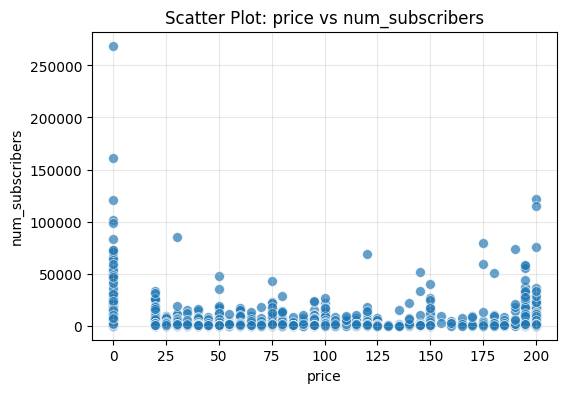

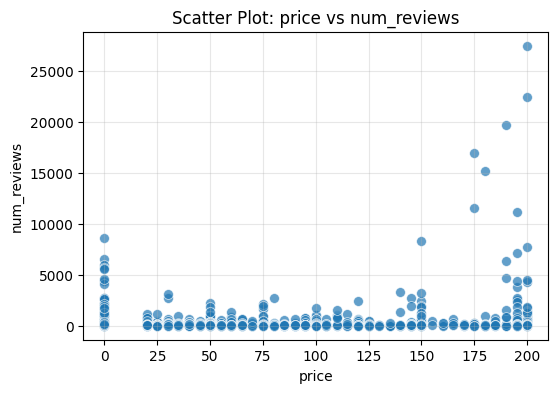

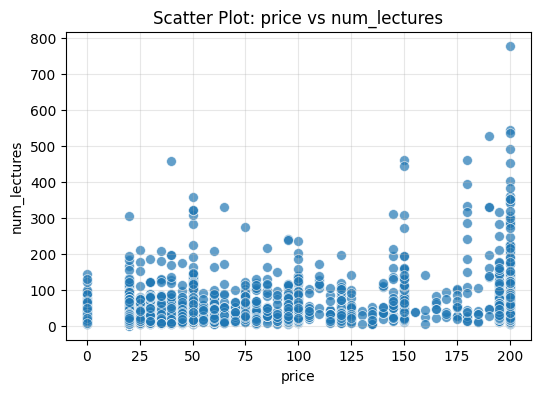

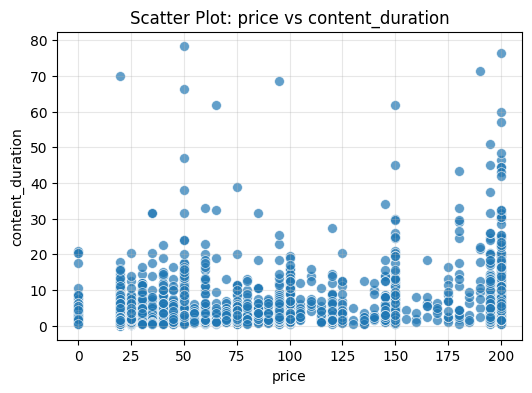

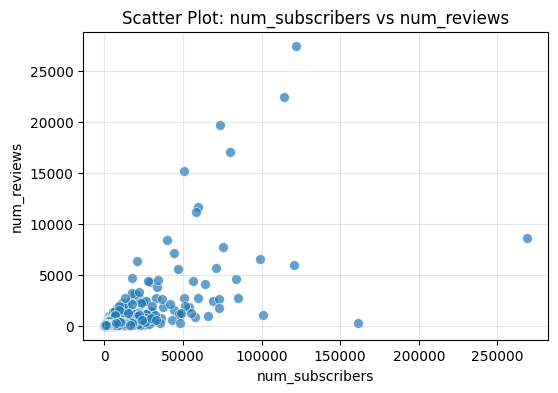

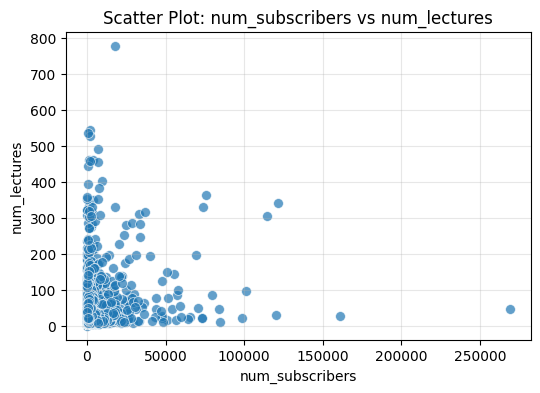

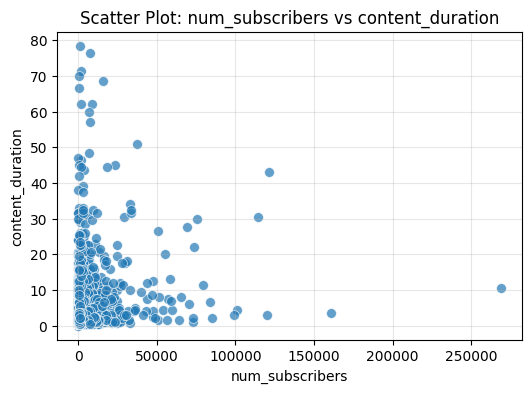

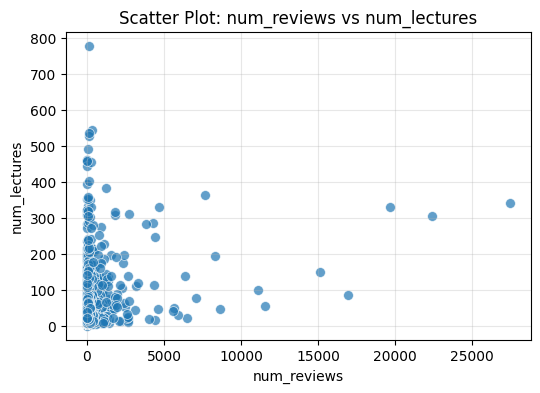

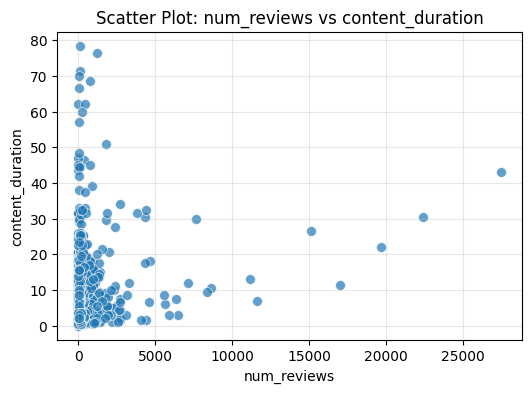

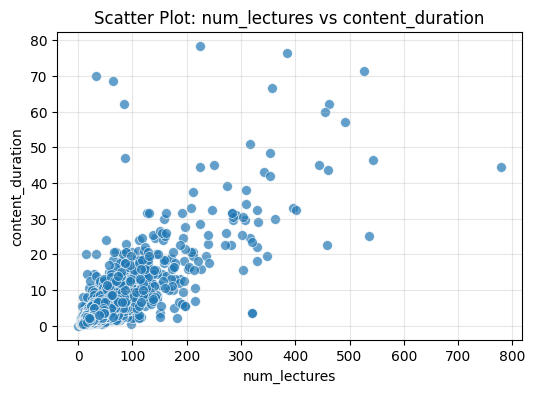

In [350]:
for i, col1 in enumerate(numeric_columns):
    for col2 in numeric_columns[i+1:]:
        plt.figure(figsize=(6, 4))
        sns.scatterplot(data=numeric_data, x=col1, y=col2, alpha=0.7, s=50)
        plt.title(f"Scatter Plot: {col1} vs {col2}")
        plt.xlabel(col1)
        plt.ylabel(col2)
        plt.grid(alpha=0.3)
        plt.show()

BOX 4: Multicollinearity - Correlation Matrix

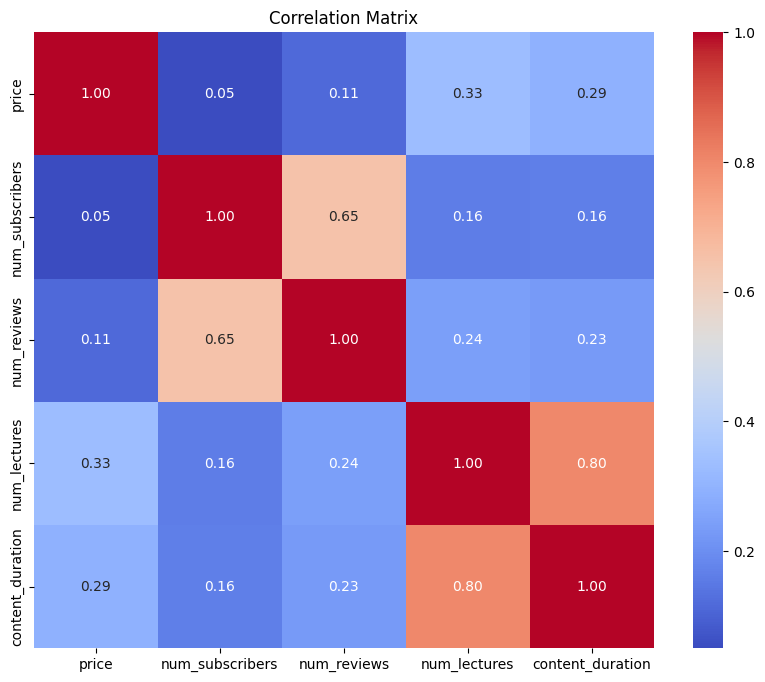

In [351]:
plt.figure(figsize=(10, 8))
sns.heatmap(X.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

STARTING THE REGRESSION

1. MULTIPLE LINEAR REGRESSION

In [352]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from math import sqrt
X = df[['num_subscribers', 'num_reviews', 'num_lectures', 'content_duration']]
y = df['price']

X = sm.add_constant(X)

model_no_log = sm.OLS(y, X).fit()

print("Linear Regression without Log Transformation:")
print(model_no_log.summary())

y_pred_no_log = model_no_log.predict(X)

rmse_no_log = sqrt(mean_squared_error(y, y_pred_no_log))
print(f'RMSE (No Log): {rmse_no_log}')




Linear Regression without Log Transformation:
                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.113
Model:                            OLS   Adj. R-squared:                  0.112
Method:                 Least Squares   F-statistic:                     117.0
Date:                Sun, 08 Dec 2024   Prob (F-statistic):           4.38e-94
Time:                        13:12:47   Log-Likelihood:                -20087.
No. Observations:                3672   AIC:                         4.018e+04
Df Residuals:                    3667   BIC:                         4.021e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------

Mean Squared Error: 9.805539610116342e-07
R-squared: 0.9999999997332303
                  Coefficient
price               61.026612
num_subscribers      0.000000
num_reviews          0.000000
num_lectures         0.000000
content_duration     0.000000


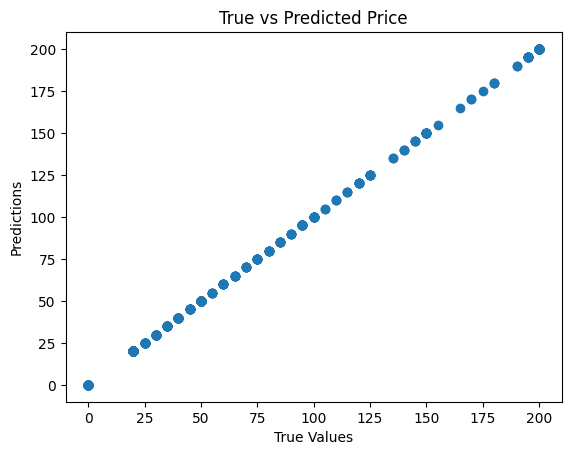

In [353]:
# Importing necessary libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

# Assuming your dataset is already loaded into 'df'
# If needed, you can load the dataset from a CSV
# df = pd.read_csv('your_data.csv')

# Select only the numeric columns
numeric_cols = ['price', 'num_subscribers', 'num_reviews', 'num_lectures', 'content_duration']

# Filter the numeric columns from the dataframe
X = df[numeric_cols]

# Handle missing values by imputing with the median
X = X.fillna(X.median())

# Prepare the target variable (price) as the dependent variable
y = df['price']  # Adjust 'price' if needed based on the actual column name

# Standardize the data (important for Lasso)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Initialize and fit the Lasso regression model
lasso = Lasso(alpha=0.001)  # You can adjust alpha (regularization strength)
lasso.fit(X_train, y_train)

# Make predictions
y_pred = lasso.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print the results
print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

# Print the coefficients to interpret the impact of each feature
coefficients = pd.DataFrame(lasso.coef_, X.columns, columns=['Coefficient'])
print(coefficients)

# Optionally, you can visualize the predicted vs actual values
import matplotlib.pyplot as plt

plt.scatter(y_test, y_pred)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('True vs Predicted Price')
plt.show()
